In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib import gridspec
import h5py
import os
plt.rcParams.update({'font.size': 14})

In [3]:
fname_DT = "TemperatureBuoyancyFree.txt"
fname_v = "VelocityBuoyancyFree.txt"

DeltaT0 = 0.62 # K
L = 0.25 # m
nu = 1.5e-5

In [4]:
Pr = 0.71
# Estimate Rayleigh Number
Ra = 10*3.3e-3*DeltaT0*L**3/(nu**2/Pr)
print("Rayleigh Number is %.2e" %Ra)

v0 = nu/L # Using Viscous Timescale
print(f"Typical Flow Scale: {v0}")

Rayleigh Number is 1.01e+06
Typical Flow Scale: 6e-05


In [5]:
# Generate Arrays to store data:
N_points = 4256

data_DT = np.zeros((9,N_points))
data_v = np.zeros((16,N_points))

In [6]:
# Read Temperature
f = open(fname_DT, "r")

for i in range(9): # skipping the first 9 rows
    trash = f.readline()
for i in range(N_points):
    data_DT[:,i] = np.fromstring(f.readline(), dtype=float, sep=' ', count=9)

x_points = data_DT[0,:]*L
y_points = data_DT[1,:]*L
DT = data_DT[2:,:]*DeltaT0

f.close()

# Read FLow
f = open(fname_v, "r")

for i in range(9): # skipping the first 9 rows
    trash = f.readline()
for i in range(N_points):
    data_v[:,i] = np.fromstring(f.readline(), dtype=float, sep=' ', count=16)

ux = data_v[2::2,:]*v0
uy = data_v[3::2,:]*v0

f.close()

In [7]:
# Define the regular grid
N = 256
dh = L/(N-1) # [m]
x = np.arange(0,N)*dh  # Regular x
y = np.arange(0,N)*dh

x_mesh, y_mesh = np.meshgrid(x, y)

In [8]:
# Which DeltaT?
i_Ra = 6

# Interpolate `DeltaT_points` onto the regular grid
points_flat= np.array([x_points.T, y_points.T]).T
DeltaT = griddata(points_flat, DT[i_Ra,:].T, (x_mesh, y_mesh), method='linear').T
vx = griddata(points_flat, ux[i_Ra,:].T, (x_mesh, y_mesh), method='linear').T
vy = griddata(points_flat, uy[i_Ra,:].T, (x_mesh, y_mesh), method='linear').T

Typical Flow Speed 1.87e-02 m/s
Typical Length Scale 0.25 m


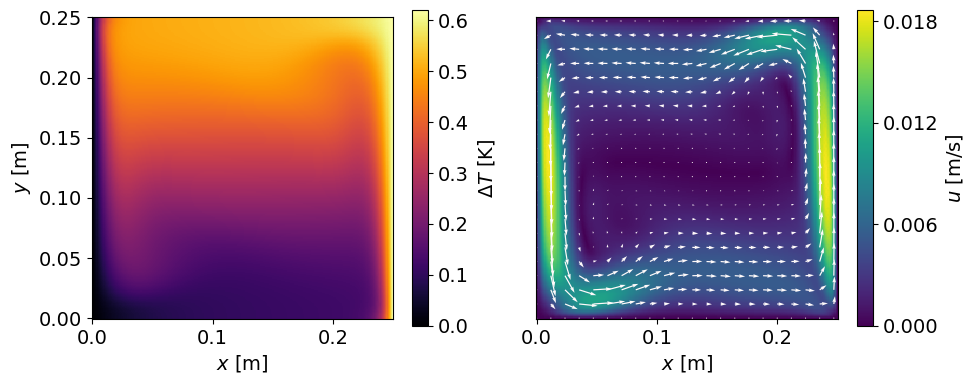

In [9]:
v_inc = 12

#Recalculate Typical Flow Speed - Dimensionless is not unit size
v0 = np.max(np.sqrt(vx**2 + vy**2))

print(f"Typical Flow Speed %.2e m/s" %v0)
print(f"Typical Length Scale %.2f m" %L)


fig = plt.figure(figsize = (10,4))
gs = gridspec.GridSpec(1,2)

#gs.update(wspace = 0.4) 

axis1 = plt.subplot(gs[0,0])
axis2 = plt.subplot(gs[0,1])

im1 = axis1.pcolormesh(x,y,DeltaT.T, cmap = "inferno")
axis1.set_aspect("equal")
axis1.set_xlabel("$x$ [m]")
axis1.set_ylabel("$y$ [m]")

cbar = fig.colorbar(im1)
cbar.set_label(label='$\Delta T$ [K]', labelpad = 5)
#cbar.set_ticks([0, 0.1, 0.2, 0.3])

im2 = axis2.pcolormesh(x,y,np.sqrt(vx**2 + vy**2).T)
axis2.quiver(x[::v_inc],y[::v_inc], vx[::v_inc,::v_inc].T, vy[::v_inc,::v_inc].T, color = 'snow', width = 0.004)
axis2.set_aspect("equal")
axis2.set_xlabel("$x$ [m]")
axis2.set_yticks([])

cbar = fig.colorbar(im2)
cbar.set_label(label='$u$ [m/s]')
cbar.set_ticks([0, 0.006, 0.012, 0.018])

plt.tight_layout()
#plt.savefig("../Figures/BuoyancyFree_True.jpg", dpi = 300, bbox_inches = "tight")
plt.show()

In [10]:
# Create an HDF5 file in write mode ('w')
with h5py.File(f'BuoyancyFree.h5', 'w') as f:
    f.create_dataset("x", data = x)
    f.create_dataset("y", data = y)
    f.create_dataset('DeltaT', data = DeltaT)
    f.create_dataset('vx', data = vx[:,:])
    f.create_dataset('vy', data = vy[:,:])
    f.create_dataset('DeltaT0', data = DeltaT0)
    f.create_dataset('v0', data = v0)
    f.create_dataset('L', data = L)

In [11]:
# Create an HDF5 file in write mode ('w') - export for Straight-ray folder
SR_folder = "../SRI_Export/"
if not os.path.exists(SR_folder):
    os.makedirs(SR_folder)
    print(f"Folder '{SR_folder}' created.")

with h5py.File(f'{SR_folder}BuoyancyFree_flattened.h5', 'w') as f:
    f.create_dataset("x", data = x_mesh.flatten())
    f.create_dataset("y", data = y_mesh.flatten())
    f.create_dataset("z", data = np.zeros(np.shape(x_mesh.flatten())))
    f.create_dataset('DeltaT', data = DeltaT.T.flatten())
    f.create_dataset('vx', data = vx[:,:].T.flatten())
    f.create_dataset('vy', data = vy[:,:].T.flatten())

Folder '../SRI_Export/' created.
